# analise de perfil dos deputados

## obj : 
neste notebook queremos olhar para os deptados em si e entender qual é o perfil desses deputados e como algumas dessas caracteristicas evoluem no tempo. 


## perguntas a serem respondidas nesse notbook: 

qual é o perfil dos puliticos que compoem a camara dos deputados no brasil ? 

para isso vamos olhar para olguns pontos: 

quantos mandatos eles possuem ? 

qual é o nivel educacional deles ? 

qual é a idade deles ? 

qual sexo ? 

eles representam os estados em que eles nasceram ? 


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from src import project_utils as pu 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import numpy as np 
import datetime as dt 
from statsmodels.graphics.gofplots import qqplot

In [2]:
con = pu.get_conection()

In [3]:
query = open('sql/query_deputados_detalhes.sql','r').read()

In [4]:
df = pd.read_sql(query,con)

In [5]:
df.head()

,id,nome,siglaPartido,siglaUf,dt_inicio_legslatuara,sexo,dataNascimento,ufNascimento,municipioNascimento,escolaridade
0,107,AGUILAR,None,AL,1826-04-29,M,NaT,None,None,None
1,123,ALBUQUERQUE,None,CE,1826-04-29,M,NaT,None,None,None
2,30,ALMEIDA E ALBUQUERQUE,None,PE,1826-04-29,M,NaT,PE,Recife,None
3,76,ALMEIDA E CASTRO,None,PE,1826-04-29,M,NaT,RN,Natal,None
4,136,ALMEIDA TORRES,None,MG,1826-04-29,M,1799-01-01,BA,None,Superior


In [6]:
df['dt_inicio_legslatuara'] = pd.to_datetime(df['dt_inicio_legslatuara'])

In [7]:
df['idade_inicio_mandato'] = (((df['dt_inicio_legslatuara']-df['dataNascimento']).dt.days)/365).round()

## numero de mandatos 

<AxesSubplot:xlabel='n_legislaturas', ylabel='Count'>

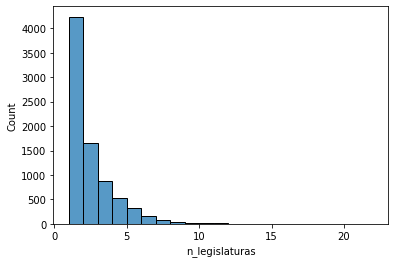

In [8]:
df_count_legislaturas = df[['nome','dt_inicio_legslatuara']]
df_count_legislaturas = df_count_legislaturas.groupby(['nome']).count().reset_index()
df_count_legislaturas.rename(columns={'nome':'nome', 'dt_inicio_legslatuara':'n_legislaturas'}, inplace= True)
sns.histplot(data=df_count_legislaturas,x='n_legislaturas',binwidth=1)

A maior parte dos deputados tem um unico mandato,  mas tem um grupo que tem um volume bem alto de mandatos 

<AxesSubplot:ylabel='n_legislaturas'>

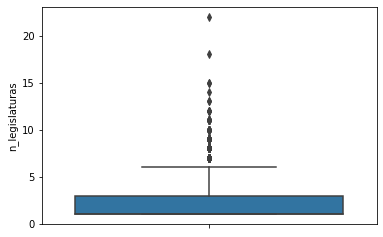

In [9]:
sns.boxplot(data=df_count_legislaturas,y='n_legislaturas')

de fato são outlayers, vamos olhar eles mais de perto 

In [10]:
df_count_legislaturas['z_score'] = np.abs(stats.zscore(df_count_legislaturas['n_legislaturas']))

Calculo do z score. 
Z score é a distancia em disvios padroes entre o valor e a media dos valores e vamos considerar qualquer valor a cima de 3 desvios padroes como um outlayers 

In [11]:
df_count_legislaturas['n_legislaturas_outlier'] = df_count_legislaturas['z_score'].apply(lambda x: True if x > 3 else False)
df_count_legislaturas[df_count_legislaturas['z_score']>3].head()

,nome,n_legislaturas,z_score,n_legislaturas_outlier
163,AGRIPINO AZEVEDO,8,3.622446,True
173,AIRES DA SILVA,7,3.011399,True
189,ALAIR FERREIRA,7,3.011399,True
192,ALAOR PRATA,7,3.011399,True
214,ALBERTO MARANHÃO,8,3.622446,True


o z_score ja fez seu rebalho, por isso vou dropar a coluna 

In [12]:
df_count_legislaturas.drop('z_score',axis='columns', inplace=True)
df_count_legislaturas.head()

,nome,n_legislaturas,n_legislaturas_outlier
0,AARÃO REIS,3,False
1,AARÃO STEINBRUCH,3,False
2,ABDALLA JALLAD,1,False
3,ABDIAS NASCIMENTO,1,False
4,ABDON BATISTA,4,False


In [13]:
df = pd.merge(df,df_count_legislaturas,on='nome',how='left')
df.head()

,id,nome,siglaPartido,siglaUf,dt_inicio_legslatuara,sexo,dataNascimento,ufNascimento,municipioNascimento,escolaridade,idade_inicio_mandato,n_legislaturas,n_legislaturas_outlier
0,107,AGUILAR,None,AL,1826-04-29,M,NaT,None,None,None,NaN,1,False
1,123,ALBUQUERQUE,None,CE,1826-04-29,M,NaT,None,None,None,NaN,3,False
2,30,ALMEIDA E ALBUQUERQUE,None,PE,1826-04-29,M,NaT,PE,Recife,None,NaN,4,False
3,76,ALMEIDA E CASTRO,None,PE,1826-04-29,M,NaT,RN,Natal,None,NaN,1,False
4,136,ALMEIDA TORRES,None,MG,1826-04-29,M,1799-01-01,BA,None,Superior,27.0,4,False


Aqui eu altero meu dataset inicial para incluir a definição de outlayers 

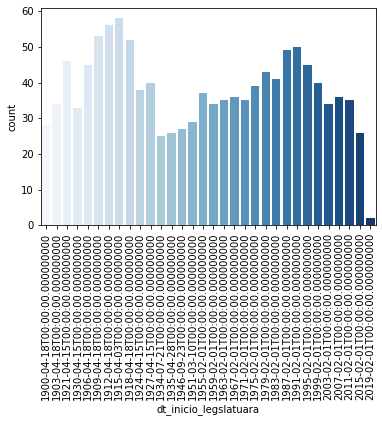

In [14]:
ax = sns.countplot(x='dt_inicio_legslatuara',
                   data=df[(df['n_legislaturas_outlier']==True) & (df['dt_inicio_legslatuara']>= dt.datetime(1900,1,1)) ],
                  palette='Blues')
ax.tick_params(axis='x', rotation=90)

Se a gente plotar o numero de outlayers por legislatura, de fato vemos uma queda brusca no volume de outlayers, o que aponta para uma renovação na camara de deputados. 

## Qual é o grau de escolaridade dos deputados ? 

Para essa resposta vamos comessar tratando os dados. Dentro do campo escolaridade temos varias entrada que podem ser agrupadas em basico, medio, superior e pos graduados. 

In [15]:
def grup_educacional(grau_escolaridade):
    basico = ['Primário Incompleto','Primário','Ginasial','Ensino Fundamental']
    medio = ['Ensino Médio Incompleto','Ensino Médio','Secundário','Secundário Incompleto','Ensino Técnico']
    superior = ['Superior Incompleto','Superior']
    pos_graduado = ['Pós-Graduação','Mestrado Incompleto','Mestrado','Doutorado Incompleto','Doutorado']
    if grau_escolaridade == None :
        return 'Nao Informado'
    elif grau_escolaridade in basico:
        return 'Ensino Fundamental'
    elif grau_escolaridade in medio:
        return 'Ensino Medio'
    elif grau_escolaridade in superior:
        return 'Ensino Superior'
    elif grau_escolaridade in pos_graduado:
        return 'Pos Graduacao'
    else:
        return None
    
df['grupo_escolaridade'] = df.escolaridade.apply(lambda x: grup_educacional(x))

<AxesSubplot:xlabel='grupo_escolaridade', ylabel='count'>

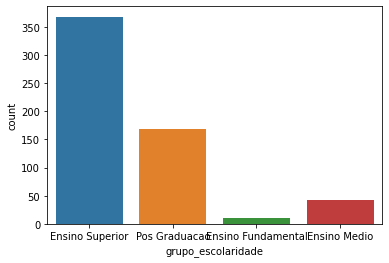

In [16]:
sns.countplot(data=df[df['dt_inicio_legslatuara'] >= dt.datetime(2019,1,1)],x='grupo_escolaridade')

Quando olhamos para o mandato atual, vemos um percentual de deptados com ensino superior completo, 
seguido logo depois pelos deputados pos graduados.

<AxesSubplot:xlabel='dt_inicio_legslatuara', ylabel='count'>

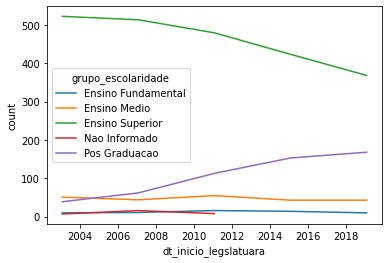

In [17]:
x = df[['dt_inicio_legslatuara','grupo_escolaridade']].groupby(['dt_inicio_legslatuara','grupo_escolaridade']).size().reset_index(name='count')
sns.lineplot(data =x[x['dt_inicio_legslatuara'] >= dt.datetime(2000,1,1)], x='dt_inicio_legslatuara',y='count',hue='grupo_escolaridade')

Interçante, temos uma queda no numero de deputados com encino superior, ao mesmo tempo que temos um almento do numero com pos graduação ou mais. (sera que esse numero segue o da população ???)

Outro ponto é um volume constante de deputados com encino basico ou com o ensino medio.  

## idade dos deutados 

<AxesSubplot:>

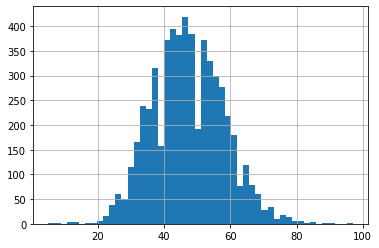

In [18]:
df[df['idade_inicio_mandato']>0].idade_inicio_mandato.hist(bins=50)

Intereçante, essa destribuição aparenta ser uma normal. 
vamos faser um teste de normalidade. 

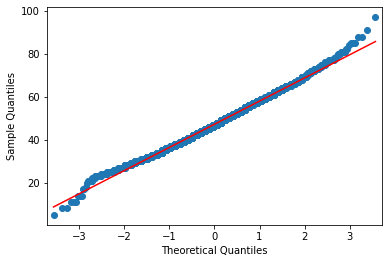

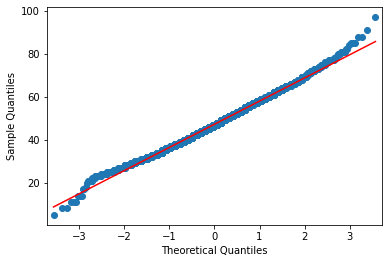

In [19]:
qqplot(df[df['idade_inicio_mandato']>0].idade_inicio_mandato,line='s')

Isso é um grafico Quantile-Quantile ele plota os valores reais da sua distribuição verços os valores de uma distribuição idealisada. sendo assim uma curva normal deveria se aproximar de uma uma linha a 45' do eixo x, essa distribuição se aproxima de uma normal. nesse caso temos uma distribuição que aparenta ser uma normal 

Mas por desencargo de conciencia (e querer aprender mais), vamos aplicar um outro teste não visual. 

No caso vamos utilizar o metodo D’Agostino’s k^2. 

Esse teste retorna 3 valores, p , Skew e Kurtosis, sendo o p o valor que nos aponta o grau de confiança na hipotese nula (h0), no caso se a nossa distribuição é uma curva normal. 

Skew nos aponta o quão deslocada para direita ou para a esquerda esta nossa distribuição, é uma medida de assimetria da distribuição. 

Kurtosis mede i quanto da nossa distribuição esta nas caldas da distribuição 

In [20]:
stat, p = stats.normaltest(df[df['idade_inicio_mandato']>0].idade_inicio_mandato)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=37.215, p=0.0000000083
Sample does not look Gaussian (reject H0)


In [21]:
stats.skew(df[df['idade_inicio_mandato']>0].idade_inicio_mandato)

0.19658141838611068

aparentimente, a distribuição tem toda a cara de uma distribuição normal, mas o skew aponta para qeue ela não seja. 

alguns fatores que podem estar contribuindo para isso: 

1) temos uma calda no lado direito da distribução, que puxa a media para cima. isso acontece por causa da existencia de idade minima de 21 ano para se candidatar, ou sejam, a distribuição fica enviesada para o lado direito, tranformando ela em uma distribução não normal. 

2) temos uma quebra na distribução proximo aos 40 e proximo aos 50, isso pode tambem impactar em como os testes vem a distribuição. 


## Qual é o sexo dos deputados ?

Antes de comessar vamos agrupar os dados por legislatura e sexo. 

In [22]:
df_sexo = df[['dt_inicio_legslatuara','sexo']].groupby(['dt_inicio_legslatuara','sexo']).size().reset_index(name='count').sort_values(['dt_inicio_legslatuara'],ascending=False)
df_sexo.head()

,dt_inicio_legslatuara,sexo,count
74,2019-02-01,M,503
73,2019-02-01,F,86
72,2015-02-01,M,567
71,2015-02-01,F,66
70,2011-02-01,M,611


[Text(0, 0.5, 'Volume de deputados'),
 Text(0.5, 0, 'Data de inicio da legislatura')]

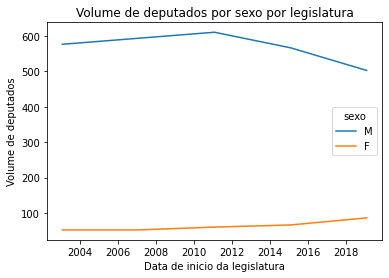

In [23]:
ax = sns.lineplot(data =df_sexo[df_sexo['dt_inicio_legslatuara'] >= dt.datetime(2000,1,1)], x='dt_inicio_legslatuara',y='count',hue='sexo')
ax.set_title('Volume de deputados por sexo por legislatura')
ax.set(ylabel='Volume de deputados', xlabel= 'Data de inicio da legislatura')

quando olhamos para a distribuição dos sexos na camara dos deputados, vemos um vies muito forte para o lado maculino, sendo que a primeira mulher a se tornar depurada só aconteceu em 1934 e levamos até 1987 para passarmos 10 mulhers com legislaturas ao mesmo tempo. 

atualmente a situaçãio não é tão melhor, só temos 86 deputadas que representam 14,6% das cadeiras. 
considerando que mulhares são 51,8% da população nacional segundo a PNAD de 2019, temos um claro problema de representatividade desse publico. 

vale resaltar, nessa analise não consideramos o volume de pessoas lgbtqia+ nessa analise, pois não temos esse dado nessa base de dados. 

## Eles representam os estados em que eles nasceram ?

Para isso vamos agrupar os dados 

In [24]:
df_uf = df[['nome','siglaUf']].groupby(['nome']).siglaUf.nunique().reset_index(name='distinct_uf')
df_uf.head()

,nome,distinct_uf
0,AARÃO REIS,1
1,AARÃO STEINBRUCH,1
2,ABDALLA JALLAD,1
3,ABDIAS NASCIMENTO,1
4,ABDON BATISTA,1


<AxesSubplot:xlabel='distinct_uf', ylabel='count'>

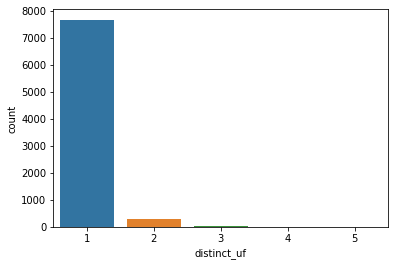

In [25]:
sns.countplot(data=df_uf,x='distinct_uf')

apaentimente os deputados sempre representam apenas um estado, com proporcionamente poucas exeçoes que mudam de estados. 
vamos olhara para elas 

In [26]:
df_uf[df_uf.distinct_uf >=3 ]

,nome,distinct_uf
346,ALMEIDA TORRES,4
348,ALMINO AFFONSO,3
448,AMÉRICO DE SOUZA,3
545,ANTONIO CARLOS,3
614,ANTÔNIO CARLOS,3
708,ARAÚJO LIMA,3
1035,BARBOSA LIMA,4
1120,BATISTA PEREIRA,3
1165,BENJAMIM FARAH,3
1216,BEZERRA DE MELO,3


São 45 depitados que apresentam esse comportamento, ou seja a exeção nesse caso. 
Mas vale ficar atento neles em analises futuras 

# conclusoes : 

## perfil : 

são principalmente homens, entre 40 e 60 anos de idade, que representam geralmente apenas 1 estado, e que em geral tem entre 1 e 3 mandatos. 

## outros pontos descobertos: 

### os deputados vem estudando mais ! 

des de 2004 aé hoje temos tido um almento siguinificativo do numero de deputados com pos graduação ou mais e que vem acompanhado de uma queda no numero de deputado com só o encino superior completo. 
tambem vemos uma base constante de deputados com só o encino findamental ou encino medio completo, que tende a se manter estavel nos proximos anos. 

### os deputados eternos. 

Historicamente temos um grupo de deputados que podemos clasificar como "deputados proficionais" pois tem longas carreiras, durando decadas na camara dos deputados chegando a ter mais de 15 mandatos (60 anos).

### A grande renovação de 2019: 

quando olhamos para o numero de "deputados proficionais" sempre temos um grupo consideravel entre 25 e 60 deputados, mas quando olhamos para a eleição de 2019 temos uma quda brusca desse grupo, o que aponta para uma renovação ou uma preferencia para o deputados com menos mandatos. 

### mulhers na camara. 

quando olhamos para a evolução do numero de deputadas, vamos um senario bem desfavoravel para elas.
A primeira deputada a se eleger só aconteceu em 1934, a 87 anos atras, e mesmo assim o volume de mulhers na camara não passa de 86. 
esse fato constrata bastante com os dados apresentados pela pnad de 2019 (dado mais recente que temos sobre o tema) que aponta que no brasil as mulheres representam 51,8% da população nacional. seguindo essa logicca, deveriamos ter por volta de 300 mulheres na camara. 
felismente o essa representação vem subindo, principalmente nas ultimas 2 legislaturas, porem ainda existe um grande caminho para que as mulheres possam ser bem representadas na camara. 
